[En français](../use-case_oafeat-interactive_fr/)

![ECCC logo](https://eccc-msc.github.io/open-data/img_eccc-logo.png)  

[TOC](../../../readme_en/) > [Usage overview](../../readme_en/) > OGC API - Features requests in Python (interactive version)

# Use case: Retrieving and displaying hydrometric data

## Introduction

Hydrometric data from the Meteorological Service of Canada (MSC), Environment and Climate Change Canada (ECCC) can be easily accessed via [GeoMet-OGC-API](https://api.weather.gc.ca/). The [OGC API - Features](https://eccc-msc.github.io/open-data/msc-geomet/web-services_en/#ogc-api-features) web services available in GeoMet-OGC-API offer the capability to query vector geospatial data and retrieve it in a GeoJSON format. The GeoJSON output file can then be used for display or further data processing. This use case will show you how you can:
* Query and retrieve vector geospatial data from GeoMet-OGC-API with [Python](https://www.python.org/)
* Display time series data in graphic and tabular format
* Create an interactive map to display geospatial data

This use case comes in two different versions. This version is conceived to be used in a Jupyter Notebook and includes more interactive features like dropdown menus to choose the value of the variables, an interactive plot with a variety of controls and an interactive map based on Leaflet. As some libraries used in this version like ipywidgets are not conceived to be used outside of a Jupyter Notebook, the [other version of this use case](../use-case_oafeat-script_en/) presents a script that is designed to be run in a terminal or an IDE.

To run the entire notebook, click on the ⏩️ symbol or select the Cell -> Run All option in the menu bar.

[![badge](https://img.shields.io/badge/Interactive%20version-binder-F5A252.svg?logo=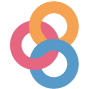)](https://mybinder.org/v2/gh/ECCC-MSC/open-data.git/master?labpath=docs%2Fusage%2Fuse-case_oafeat%2Fuse-case_oafeat-script_en.ipynb)

## Creation of a tool to monitor water levels

Cathy runs a boat tours and water sports company in Chilliwack, British-Columbia. She would like to track the water levels of a few hydrometric stations near her city to guide the management of the company's activities. She would like to have:
* The daily mean water levels of a three months period for all hydrometric stations located within 100 km of the city of Chilliwack
* Graphic and tabular views that present the daily mean water levels of that three months period
* An interactive map that displays the hydrometric stations located within 100 km of the city of Chilliwack and the most recent daily mean water level of these stations in the determined time period

To achieve this, the first step is to import the necessary Python modules and to select the desired request parameters.

In [1]:
# Modules importation
from datetime import date
import json

from ipyleaflet import (
    AwesomeIcon,
    basemaps,
    FullScreenControl,
    Map,
    Marker,
    ScaleControl,
    WidgetControl,
)
from ipywidgets import HTML, interact
from osgeo import ogr, osr
from owslib.ogcapi.features import Features
import numpy as np
import pandas as pd

In [2]:
# Parameters

# Coordinates of Chilliwack
lat = 49.162676
long = -121.958943

# Buffer size in kilometres
buffer = 100

# Start and end of the time period for which the data will be retrieved
start_date = date(2018, 6, 1)
end_date = date(2018, 8, 31)

# ESPG code of the preferred projection to create the buffer
# NAD83 / Statistics Canada Lambert
projection = 3347

In [3]:
# Parameters formatting for the OGC API - Features request

# Bounding box a little bigger than buffer size

# The buffer needs to be transformed in degrees to get
# the coordinates of the corners of the bounding box:
# Latitude: 1 km ≈ 0.009° 
# Longitude (at the 49th parallel): 1 km ≈ 0.014°
bbox = [
    long - buffer * 0.02,
    lat - buffer * 0.01,
    long + buffer * 0.02,
    lat + buffer * 0.01,
]

# Formatting of the selected time period
time_ = f"{start_date}/{end_date}"

Then, the [hydrometric monitoring stations data](https://api.weather.gc.ca/collections/hydrometric-stations) available on GeoMet-OGC-API can be retrieved with the [OWSLib package](https://geopython.github.io/OWSLib/). As the bounding box parameter is not as precise as a round buffer, [GDAL](https://gdal.org/api/index.html#python-api) can be used to select only the hydrometric stations that are strictly inside a 100 km radius from Chilliwack.

In [4]:
# Retrieval of hydrometric stations data
oafeat = Features("https://api.weather.gc.ca/")
station_data = oafeat.collection_items(
    "hydrometric-stations", bbox=bbox, STATUS_EN="Active"
)

# Verification of the retrieved data
if "features" in station_data:
    station_data = json.dumps(station_data, indent=4)
else:
    raise ValueError(
        "No hydrometric stations were found. Please verify the coordinates."
    )

In [5]:
# List of stations located inside the buffer zone

# Accessing the hydrometric stations layer
driver = ogr.GetDriverByName("GeoJSON")
data_source = driver.Open(station_data, 0)
layer = data_source.GetLayer()

# Identification of the input spatial reference system (SRS)
SRS_input = layer.GetSpatialRef()
SR = osr.SpatialReference(str(SRS_input))
epsg = SR.GetAuthorityCode(None)
SRS_input.ImportFromEPSG(int(epsg))

# Definition of the SRS used to project data
SRS_projected = osr.SpatialReference()
SRS_projected.ImportFromEPSG(projection)

# Transformation from input SRS to the prefered projection
transform = osr.CoordinateTransformation(SRS_input, SRS_projected)

# Creation of a buffer to select stations
point = ogr.Geometry(ogr.wkbPoint)
point.AddPoint(long, lat)
point.Transform(transform)
point_buffer = point.Buffer(buffer * 1000)  # The value must be in meters

# Selection of the stations in the buffer zone
stations = []

for feature in layer:
    geom = feature.GetGeometryRef().Clone()
    geom.Transform(transform)
    if geom.Intersects(point_buffer):
        stations.append(feature.STATION_NUMBER)

# Raising an error if no station were found
if not stations:
    raise ValueError(
        f"There are no hydrometric stations within {buffer} km"
        + " of the chosen coordinates. Please verify the coordinates."
    )

Once the hydrometric monitoring stations located within 100 km of Chilliwack are identified, the water level data for a three months period can be retrieved for each station. 

The daily mean water levels of the three months period will be used to create a data frame for each station with [Pandas](https://pandas.pydata.org/). To facilitate the data manipulations, all the data frames will be gathered in a Python dictionary. These data frames will be used to create interactive graphic and tabular views of the historical daily mean water levels of the hydrometric monitoring stations located within 100 km of Chilliwack. They will also be used to display the hydrometric stations on a map with their most recent daily mean water level data for the time period.

Stations that do not have water level data available in the desired time period will be removed from the dataset.

In [6]:
# Retrieval of hydrometric data for each station

# Dictionary that will contain a data frame for each station with
# the historical daily mean water levels for the time period
hydrometric_data = {}

# List of stations with no water level data
stations_without_data = []

# Data retrieval and creation of the data frames
for station in stations:

    # Retrieval of water level data
    hydro_data = oafeat.collection_items(
        "hydrometric-daily-mean",
        bbox=bbox,
        time_=f"{start_date}/{end_date}",
        STATION_NUMBER=station,
    )
    # Creation of a data frame if there is data for the chosen time period
    if hydro_data["features"]:
        # Creation of a dictionary in a format compatible with Pandas
        historical_data_format = [
            {
                "LATITUDE": el["geometry"]["coordinates"][1],
                "LONGITUDE": el["geometry"]["coordinates"][0],
                **el["properties"],
            }
            for el in hydro_data["features"]
        ]
        # Creation of the data frame
        historical_data_df = pd.DataFrame(
            historical_data_format,
            columns=[
                "STATION_NUMBER",
                "STATION_NAME",
                "DATE",
                "LEVEL",
                "LATITUDE",
                "LONGITUDE",
            ],
        )
        historical_data_df = historical_data_df.fillna(value=np.nan)
        # Adding the data frame to the hydrometric data dictionary
        if not historical_data_df["LEVEL"].isnull().all():
            # Removing any rows without water level data at the
            # end of the data frame
            while np.isnan(historical_data_df["LEVEL"].iloc[-1]):
                historical_data_df = historical_data_df.drop(
                    historical_data_df.tail(1).index
                )
            # Creating an index with the date in a datetime format
            historical_data_df["DATE"] = pd.to_datetime(
                historical_data_df["DATE"]
            )
            historical_data_df.set_index(["DATE"], inplace=True, drop=True)
            historical_data_df.index = historical_data_df.index.date
            # Adding the data frame to the dictionary
            hydrometric_data[station] = historical_data_df
        # If all the data is NaN, the station will be removed from the dataset
        else:
            stations_without_data.append(station)
    # If there is no data for the chosen time period, the station
    # will be removed from the dataset
    else:
        stations_without_data.append(station)

# Removing hydrometric stations without water level data from the station list
for station in stations_without_data:
    stations.remove(station)

# Raising an error if no station is left in the list
if not stations:
    raise ValueError(
        f"No water level data is available for this {num_months}"
        + " months period for the selected hydrometric stations."
    )

Now that all the data frames are ready, the data can be visualized in a graphic view. Pandas can be used to generate interactive plots in a Jupyter Notebook with the [Plotly backend](https://plotly.com/python/pandas-backend/). A dropdown menu can be added in a Jupyter Notebook with [ipywidgets](https://ipywidgets.readthedocs.io/en/stable/) to select the desired hydrometric monitoring station.

In [7]:
# Creation of an interactive plot with Pandas and Plotly
pd.options.plotting.backend = "plotly"


# Function to show the plot of the chosen hydrometric station
def choose_station(station):
    # Creation of the plot
    fig = hydrometric_data[station]["LEVEL"].plot(
        title=(
            "Water levels at station "
            + f"{hydrometric_data[station]['STATION_NAME'][0]}"
            + f" ({station})"
        ),
        template="plotly_white",
        labels={
            "index": "Date",
            "value": "Water level (m)",
            "variable": "Legend"
        },
        color_discrete_sequence=["RoyalBlue"],
    )
    # Updating plot parameters
    fig.update_traces(
        name="Daily mean",
        mode="lines+markers",
        hovertemplate=None,
        hoverinfo="x+name+y",
    )
    fig.update_layout(
        hovermode="x unified",
    )
    return fig


# Creation of the dropdown menu widget
graph = interact(choose_station, station=stations)

interactive(children=(Dropdown(description='station', options=('08GA010', '08GA030', '08GA077', '08GA079', '08…

A similar dropdown widget can be used to select which hydrometric monitoring station data to show in the interactive data table.

In [8]:
# Creation of the table

# Option to show all rows
pd.set_option("max_rows", None)


# Function to show the table of the chosen hydrometric station
def choose_station_table(station):
    # Creation of a HTML widget to add a title to the table
    table_title = HTML(
        value=(
            "<h4>Water levels at station "
            + f"{hydrometric_data[station]['STATION_NAME'][0]}"
            + f" ({station})</h4>"
        )
    )
    # Selecting the desired columns and changing the columns names
    displayed_df = hydrometric_data[station][["LEVEL"]].rename(
        columns={
            "LEVEL": "Water level daily mean (m)",
        }
    )
    displayed_df.index = displayed_df.index.rename("Date")
    return display(table_title), display(displayed_df)


# Creation of the dropdown menu widget
table = interact(choose_station_table, station=stations)

interactive(children=(Dropdown(description='station', options=('08GA010', '08GA030', '08GA077', '08GA079', '08…

Finally, an interactive map can be created with [ipyleaflet](https://ipyleaflet.readthedocs.io/) to display the most recent water level daily mean of all the hydrometric monitoring stations located within 100 km of Chilliwack for the selected three months period.

In [9]:
# Creation of the interactive map

# Latitude at the center of the station points (to center map)
latitudes = [hydrometric_data[station]["LATITUDE"][0] for station in stations]
center_lat = (min(latitudes) + max(latitudes)) / 2

# Parameters
center = [center_lat, long]
zoom = 8

# Map
m = Map(basemap=basemaps.CartoDB.Positron, center=center, zoom=zoom)

# Adding title
display(HTML(
        value=(
            "<h4>Most recent daily mean water level for the "
            + f"time period ending the {end_date}</h4>"
        )
    )
)

# Adding hover information
html = HTML("Hover over Hydrometric Stations")
html.layout.margin = "0px 10px 10px 10px"
control = WidgetControl(widget=html, position="topright", max_width=250)
m.add_control(control)


def get_callback(marker):
    def callback(*args, **kwargs):
        html.value = (
            f"<b>{marker.STATION_NAME}</b><br>"
            + f"Station ID: {marker.STATION_NUMBER}<br>"
            + f"Date: {marker.name}<br>"
            + f"Water level: {round(marker.LEVEL, 2)} m"
        )

    return callback


# Adding scale and full screen control
m.add_control(ScaleControl(position="bottomleft"))
m.add_control(FullScreenControl())

# Adding a marker to the map for each hydrometric station
for station in stations:
    latest_data = hydrometric_data[station].iloc[-1]
    icon = AwesomeIcon(name="tint", marker_color="darkblue")
    station_marker = Marker(
        icon=icon,
        location=[latest_data.LATITUDE, latest_data.LONGITUDE],
        draggable=False,
    )
    station_marker.on_mouseover(get_callback(latest_data))
    m.add_layer(station_marker)

# Display the map
display(m)

HTML(value='<h4>Most recent daily mean water level for the time period ending the 2018-08-31</h4>')

Map(center=[49.34332084655762, -121.958943], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_…

## Conclusion

Cathy has now a good overview of the water levels of the rivers and lakes near her. This information will help her plan her boat tours and water sports company activities. After completing this use case, you should be able to use Python to retrieve and process geospatial data from GeoMet-OGC-API and to display data in different interactive formats (plot, table and map). This use case can be adapted to fit your needs by changing the parameters or modifying the data processing steps.